In [1]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm
import seaborn as sns
import os
import pickle
# sns.set_style("dark")
from utils import *

In [2]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = 'custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['export']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 80
# time management
minTime = 60
maxTime = 12 * 3600
timeColumnName = 'time'
logarithmicTime = False
excludeVariables = ['battery_discharge_time']
# One or more variables are considered random and "flattened"
seedVars = ['seed']
# Label mapping


In [3]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file, excludeVariables))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file, excludeVariables)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }
    
for experiment in experiments:
    current_experiment_means = means[experiment]
    current_experiment_errors = stdevs[experiment]

In [4]:
current_experiment_means

<xarray.Dataset>
Dimensions:                  (balance: 6, device_count: 3, epi_ratio: 2,
                              cloud_epi: 3, time: 80)
Coordinates:
  * balance                  (balance) <U10 '[0, 100]' ... '[40, 80]'
  * device_count             (device_count) float64 100.0 300.0 1e+03
  * epi_ratio                (epi_ratio) float64 3.0 30.0
  * cloud_epi                (cloud_epi) float64 3.0 30.0 300.0
  * time                     (time) float64 60.0 606.1 ... 4.265e+04 4.32e+04
Data variables:
    behaviourInDevice[sum]   (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    behaviourInCloud[sum]    (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    batteryPercentage[mean]  (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    batteryConsumption[sum]  (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    cloudConsumption[sum]    (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    totalConsumption[sum]    (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    isCharging[sum]          (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    isMoving[sum]            (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    distance[sum]            (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    distance[mean]           (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    cloudCost                (balance, device_count, epi_ratio, cloud_epi, time) float64 ...
    instances                (balance, device_count, epi_ratio, cloud_epi, time) float64 ...

In [5]:
chart_data = current_experiment_means[
    { 'batteryConsumption[sum]', 'cloudConsumption[sum]', 'instances', 'distance[mean]' }
].mean(dim = { 'epi_ratio', 'time', 'cloud_epi' }, skipna = True)
chart_errors = current_experiment_errors[
    { 'batteryConsumption[sum]', 'cloudConsumption[sum]', 'instances', 'distance[mean]' }
].mean(dim = { 'epi_ratio', 'time', 'cloud_epi' }, skipna = True)
chart_data

<xarray.Dataset>
Dimensions:                  (balance: 6, device_count: 3)
Coordinates:
  * balance                  (balance) <U10 '[0, 100]' ... '[40, 80]'
  * device_count             (device_count) float64 100.0 300.0 1e+03
Data variables:
    batteryConsumption[sum]  (balance, device_count) float64 270.7 ... 2.039e+03
    distance[mean]           (balance, device_count) float64 14.09 ... 16.05
    instances                (balance, device_count) float64 0.0 0.0 ... 128.6
    cloudConsumption[sum]    (balance, device_count) float64 0.0 ... 2.562e+04

In [6]:
device_count_coordinates = chart_data.coords['device_count']
device_count_coordinates

<xarray.DataArray 'device_count' (device_count: 3)>
array([ 100.,  300., 1000.])
Coordinates:
  * device_count  (device_count) float64 100.0 300.0 1e+03

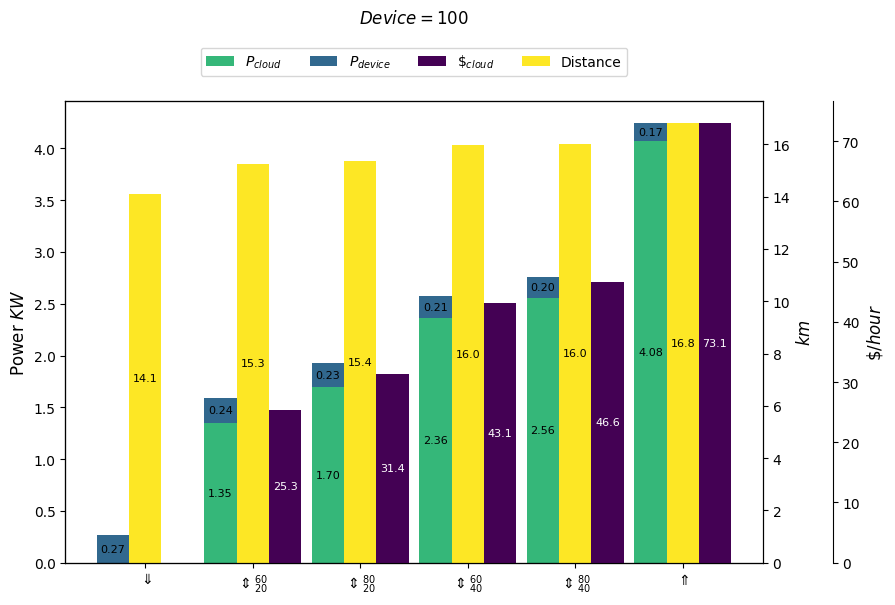

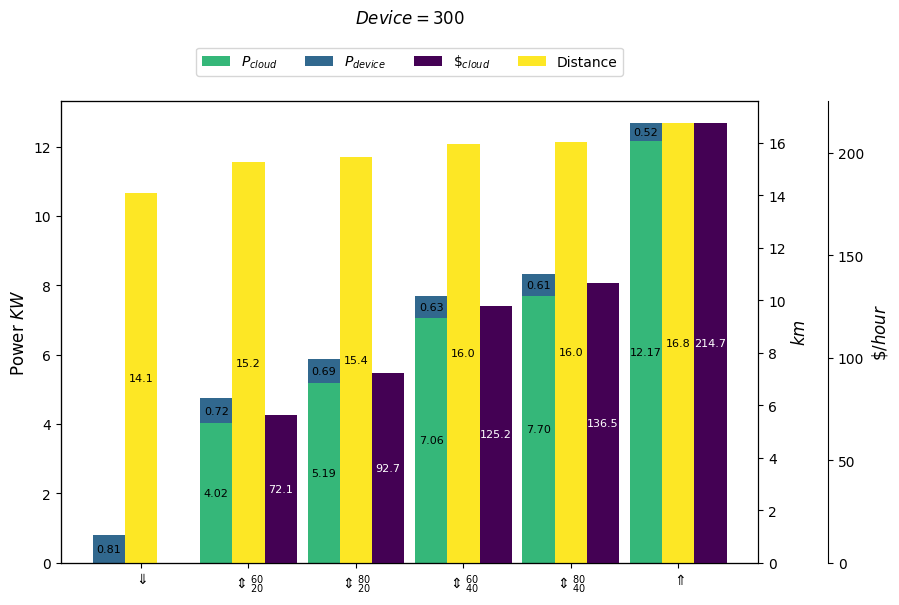

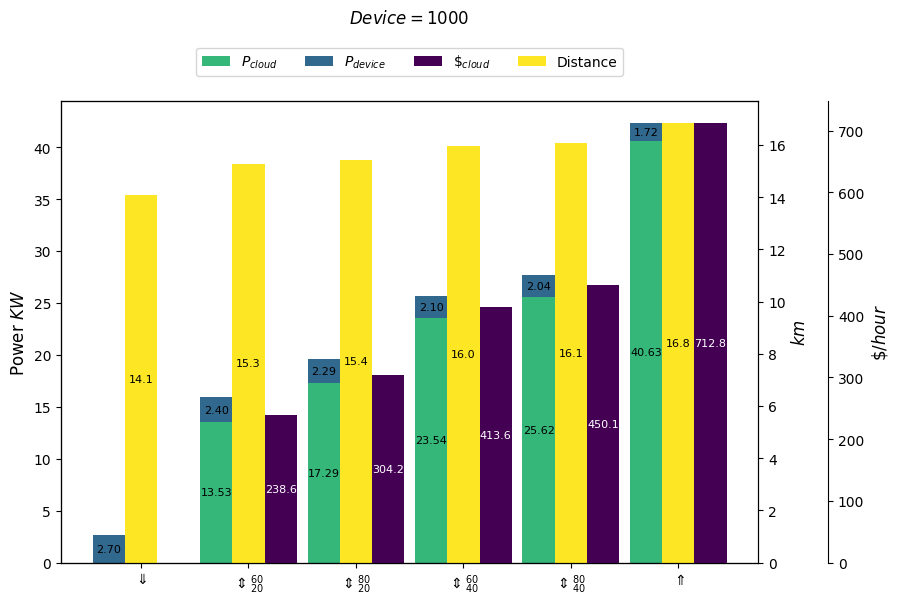

In [7]:
device_count_values = chart_data['device_count'].values

aws_cloud_cost = 3.5 # $/h

def to_latex_label(labels):
    regex = r"^\[(?P<low>\d+), (?P<high>\d+)\]$"
    out = []
    for scenario in labels:
        result = re.findall(regex, scenario)
        for low, high in result:
            if high == '101' and low == '101':
                out.append(r'$\Uparrow$')
            elif low == '0':
                out.append(r'$\Downarrow$')
            else:
                out.append('$\\Updownarrow_{' + low + '}^{' + high + '}$')
    return out

for comb in device_count_values:
    raw_data = chart_data.sel({'device_count': comb}).sortby('instances')
    raw_errors = chart_errors.sel({'device_count': comb})
    
    chart_with_cost = raw_data.assign(cloud_cost=lambda x: x.instances * aws_cloud_cost)
    chart_with_cost = chart_with_cost.assign(device_power=lambda x: x['batteryConsumption[sum]'] / 1000)
    chart_with_cost = chart_with_cost.assign(cloud_power=lambda x: x['cloudConsumption[sum]'] / 1000)

    errors_with_cost = raw_errors.assign(cloud_cost=lambda x: x.instances * aws_cloud_cost)
    errors_with_cost = errors_with_cost.assign(device_power=lambda x: x['batteryConsumption[sum]'] / 1000)
    errors_with_cost = errors_with_cost.assign(cloud_power=lambda x: x['cloudConsumption[sum]'] / 1000)

    chart_pd = chart_with_cost.to_dataframe()
    errors_pd = errors_with_cost.to_dataframe()

    device_consumption_values = chart_pd['device_power'].values
    device_consumption_error = errors_pd['device_power'].values

    cloud_consumption_values = chart_pd['cloud_power'].values
    cloud_consumption_error = errors_pd['cloud_power'].values

    distance_values = chart_pd['distance[mean]'].values
    distance_error = errors_pd['distance[mean]'].values

    cost_values = chart_pd['cloud_cost'].values
    cost_error = errors_pd['cloud_cost'].values

    bar_width = 0.30

    fig, ax = plt.subplots(figsize=(9,6))
    distance_x = ax.twinx()
    cost_x = ax.twinx()
    
    scenarios = to_latex_label(raw_data['balance'].to_numpy())
    ordered = scenarios.copy()
    ordered.append(ordered.pop(1))
    x = np.arange(len(scenarios))

    # c = ax.bar(scenarios, cloud_consumption_values, yerr=cloud_consumption_error, width=bar_width, label=r'$P_{cloud}$', color='#35b779')
    c = ax.bar(scenarios, cloud_consumption_values, width=bar_width, label=r'$P_{cloud}$', color='#35b779')
    # d = ax.bar(scenarios, device_consumption_values, yerr=device_consumption_error, width=bar_width, bottom=cloud_consumption_values, label=r'$P_{battery}$', color='#31688e')
    d = ax.bar(scenarios, device_consumption_values, width=bar_width, bottom=cloud_consumption_values, label=r'$P_{battery}$', color='#31688e')
    # dis = distance_x.bar(x + bar_width, distance_values, yerr=distance_error, width=bar_width, label='Distance', color='#fde725')
    dis = distance_x.bar(x + bar_width, distance_values, width=bar_width, label='Distance', color='#fde725')
    # cost = cost_x.bar(x + 2 * bar_width, cost_values, yerr=cost_error, width=bar_width, label=r'$\$_{cloud}$', color='#440154')
    cost = cost_x.bar(x + 2 * bar_width, cost_values, width=bar_width, label=r'$\$_{cloud}$', color='#440154')

    for c in ax.containers:
        labels = [f'{h:0.2f}' if (h := v.get_height()) != 0 else '' for v in c ]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8)
    distance_x.bar_label(dis, label_type='center', fmt='%.1f', fontsize=8)
    for c in cost_x.containers:
        labels = [f'{h:0.1f}' if (h := v.get_height()) != 0 else '' for v in c ]
        cost_x.bar_label(c, labels=labels, label_type='center', fontsize=8, color='white')

    plt.xticks(x + bar_width, scenarios)
    cost_x.spines.right.set_position(("axes", 1.10))

    ax.set_ylabel(r'Power $KW$', fontsize=12)
    cost_x.set_ylabel(r'$\$ / hour$', fontsize=12)
    distance_x.set_ylabel('$km$', fontsize=12)

    plt.title(f'$Device = {int(comb)}$', loc='center', y=1.15)

    lines, _ = ax.get_legend_handles_labels()
    lines2, labels2 = cost_x.get_legend_handles_labels()
    lines3, labels3 = distance_x.get_legend_handles_labels()
    ax.legend().remove()
    cost_x.legend().remove()
    distance_x.legend(lines + lines2 + lines3, [r'$P_{cloud}$', r'$P_{device}$'] + labels2 + labels3, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.13))

    plt.show()